In [2]:
import boto3
import requests
import random
import numpy as np
import tempfile
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image, display, clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
s3 = boto3.resource('s3')
bucket_name = 'eye-of-the-needle'
bucket = s3.Bucket(bucket_name)
files = [file.key for file in bucket.objects.filter()]

In [4]:
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record
    
def label_imgs(n=4):
    record = get_record()
    inp = 1
    while inp != 'q':
        # Clean slate
        clear_output()
#         for k, v in record.items():
#             print(k)
        scores = sum(v['score'] for k, v in record.items())
        print(f"{scores} great photos out of {len(record.keys())} photos scored")
        
        # Get list of n never-before-seen images
        n_files = []
        while len(n_files) < n:
            f = random.choice(files)
            if f not in record:
                n_files.append(f)
        
        print("\nDisplaying:")
        print(n_files)
        fig = plt.figure(figsize=(35,25))
        for i, file in enumerate(n_files):
            obj = bucket.Object(file)
            tmp = tempfile.NamedTemporaryFile()
            with open(tmp.name, 'wb') as f:
                obj.download_fileobj(f)
                img=mpimg.imread(tmp.name)
            ax = fig.add_subplot(n, 1, i + 1) 
            ax.imshow(img)
        plt.show()
        
        # Get scores
        inp = input()
        for i, image in enumerate(n_files):
            print(image, record[image])
            record[image]['score'] = record[image].get('score', 0) + (str(i + 1) in inp)
            record[image]['matches'] = record[image].get('matches', 0) + 1
        save_to(record, record_path)
        
    save_to(record, '../data/raw/record_backup.pkl')
    
    matches = sum(record[k]['matches'] for k in record.keys())
    
    return record

188 great photos out of 820 photos scored

Displaying:
['2019/05/31/2019_0531_103000/thumbnail.jpg', '2019/02/11/2019_0211_104000/thumbnail.jpg', '2019/03/08/2019_0308_190000/thumbnail.jpg', '2018/03/08/2018_0308_190000/thumbnail.jpg']


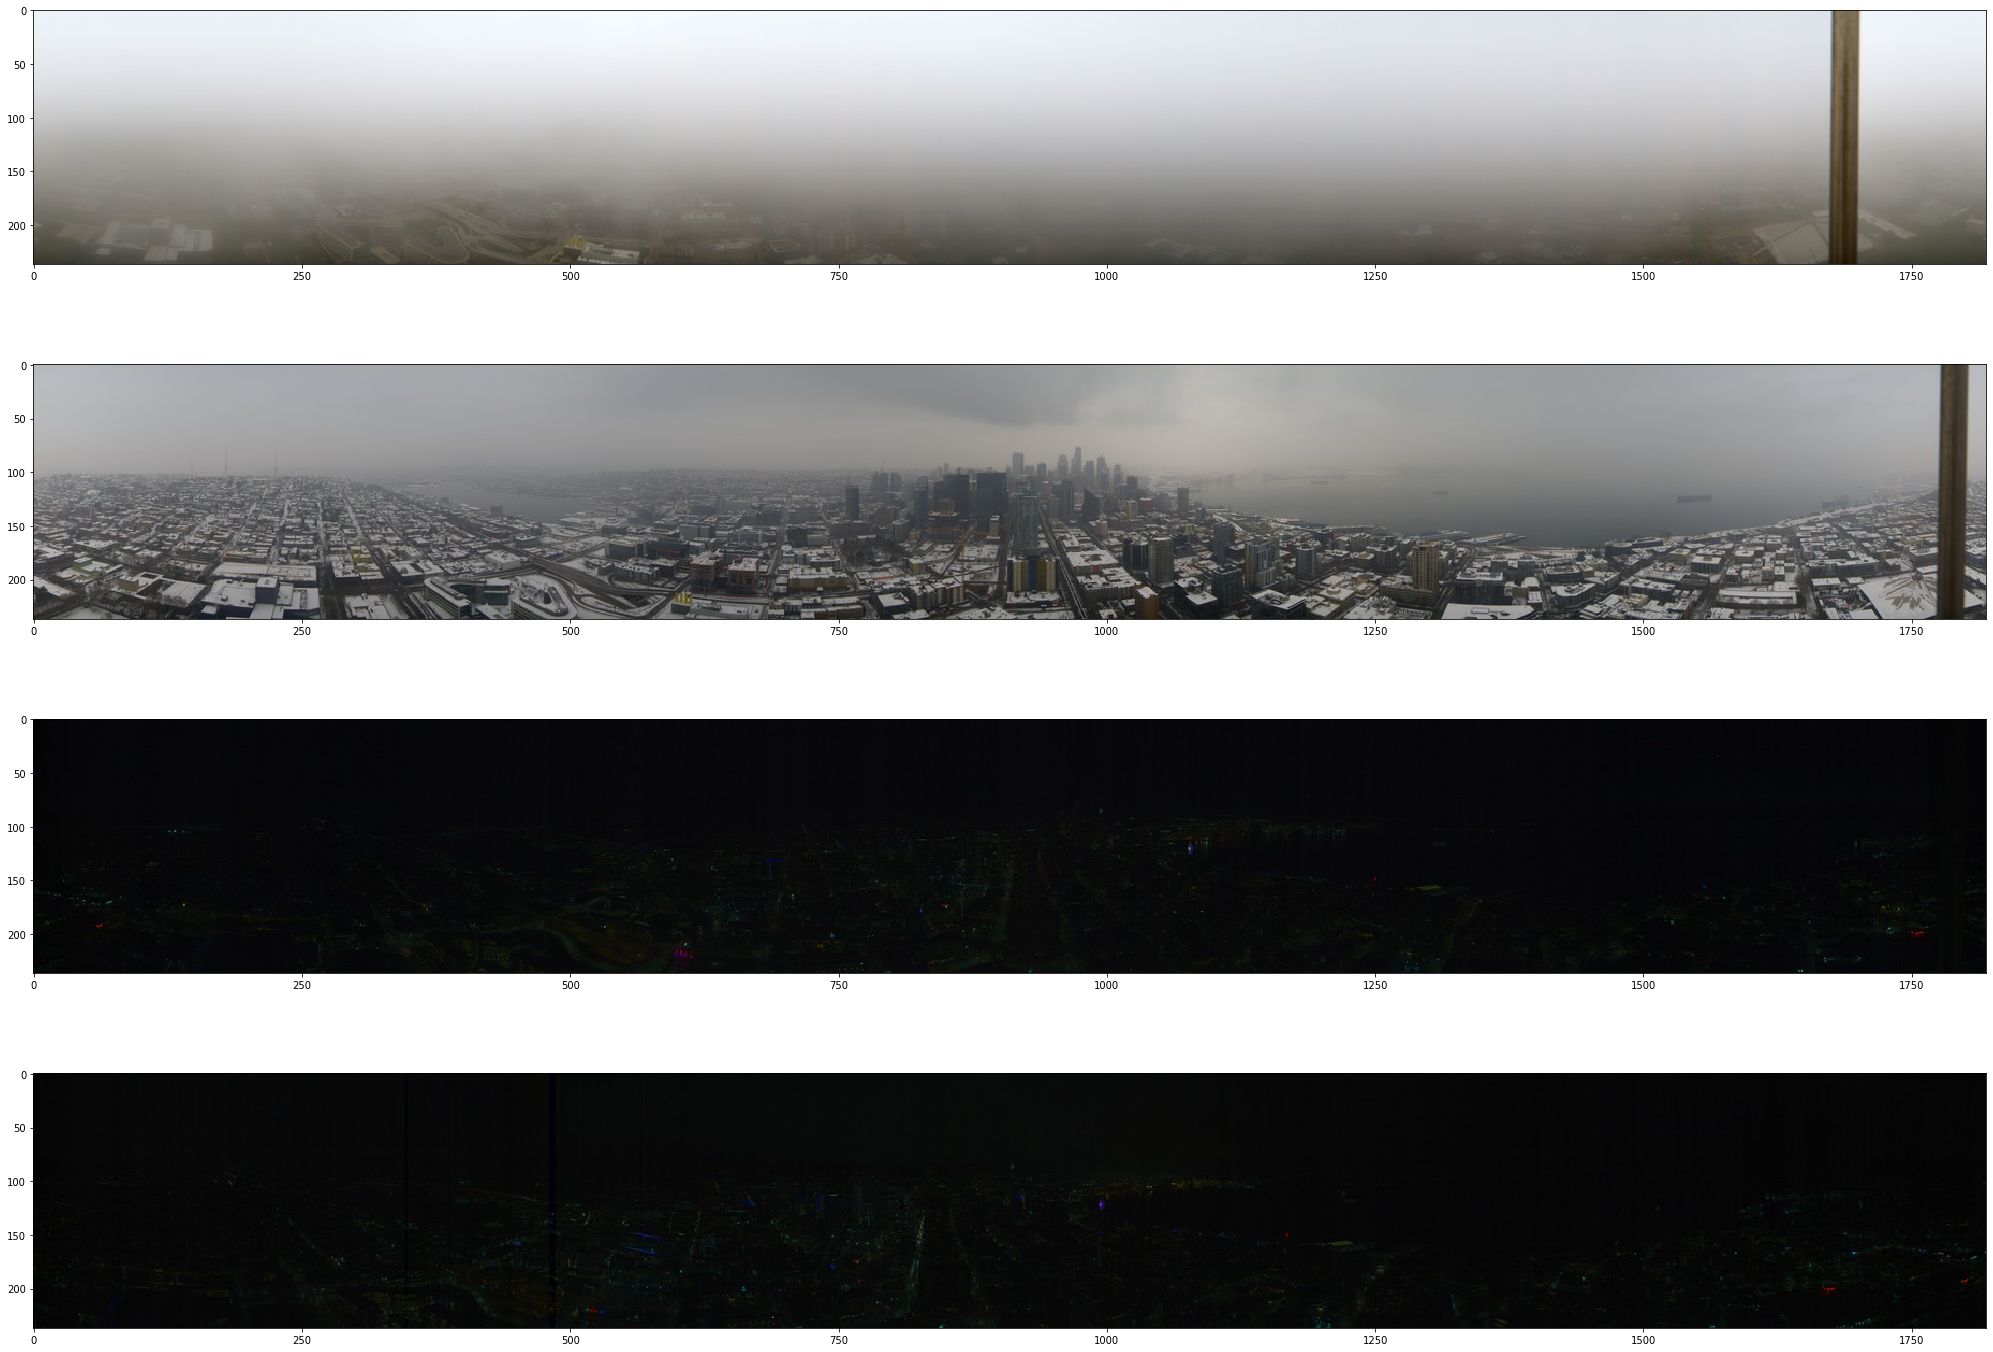

q
2019/05/31/2019_0531_103000/thumbnail.jpg {}
2019/02/11/2019_0211_104000/thumbnail.jpg {}
2019/03/08/2019_0308_190000/thumbnail.jpg {}
2018/03/08/2018_0308_190000/thumbnail.jpg {}
Saved file to ../data/raw/record.pkl
Saved file to ../data/raw/record_backup.pkl


In [5]:
scores = label_imgs(4)

In [161]:
record = defaultdict(dict)
for f, s in scores.items():
    record[f] = {
        'score': s['score'],
        'matches': 1
    }
record

defaultdict(dict,
            {'2018/09/03/2018_0903_083000/thumbnail.jpg': {'score': 1,
              'matches': 1},
             '2017/12/08/2017_1208_115000/thumbnail.jpg': {'score': 1,
              'matches': 1},
             '2019/04/29/2019_0429_201000/thumbnail.jpg': {'score': 1,
              'matches': 1},
             '2018/01/15/2018_0115_081000/thumbnail.jpg': {'score': 1,
              'matches': 1},
             '2017/12/05/2017_1205_160000/thumbnail.jpg': {'score': 1,
              'matches': 1},
             '2018/04/06/2018_0406_061000/thumbnail.jpg': {'score': 0,
              'matches': 1},
             '2019/05/07/2019_0507_200000/thumbnail.jpg': {'score': 0,
              'matches': 1},
             '2018/12/27/2018_1227_113000/thumbnail.jpg': {'score': 0,
              'matches': 1},
             '2019/04/09/2019_0409_095000/thumbnail.jpg': {'score': 0,
              'matches': 1},
             '2018/04/09/2018_0409_170000/thumbnail.jpg': {'score': 0,
           

In [83]:
len(record)

172

In [95]:
sum(record[k]['score'] for k in record.keys())

33

In [90]:
sum(record[k]['matches'] for k in record.keys())

172

In [162]:
record_path = '../data/raw/record.pkl'
save_to(record, record_path)
save_to(record, '../data/raw/record_backup.pkl')

Saved file to ../data/raw/record.pkl
Saved file to ../data/raw/record_backup.pkl


# Helpers

In [1]:
import os
import pickle

def load_or_make(filepath, overwrite='n'):
    def decorator(func):
        def wraps(*args, **kwargs):
            if overwrite == 'y':
                ow = input(f'Are you sure you want to overwrite {filepath}? y/n: ')
                if (os.path.exists(filepath)) and (ow == 'y'):
                    os.remove(filepath)
            try:
                with open(filepath, 'rb') as f:
                    data = pickle.load(f)
            except:
                data = func(*args, **kwargs)
                with open(filepath, 'wb') as to_write:
                    pickle.dump(data, to_write)
            return data
        return wraps
    return decorator


def save_to(item, filepath, verbose=True):
    """
    Pickles item sand saves it to path
    Input: object to be pickled, string containing directory and filename
    Output: pickled object stored to provided path
    """
    with open(filepath, 'wb') as to_write:
        pickle.dump(item, to_write, protocol=2)
    if verbose:
        print(f'Saved file to {filepath}')
    return


def load_from(filepath, verbose=True):
    """
    Unpickles item and returns item from path
    Input: filepath to pickled object
    Output: unpickled object
    """
    if not file_exists(filepath):
        print(f'Failed to load from {filepath}. Does not exist.')
    with open(filepath, 'rb') as f:
        item = pickle.load(f)
    if verbose:
        print(f'Loaded file from {filepath}')
    return item


def file_exists(filepath):
    """
    Returns True if specified file already exists, else False
    Input:
        path (str), path to directory containing file
        filename (str), name of file to check for
    Output: True if specified file already exists, else False
    """
    file_exists = os.path.isfile(filepath)
    return file_exists

